# Importing Libraries

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, log_loss, f1_score
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe, fmin, Trials, space_eval
import warnings
import shap
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from Functions_George import read_txt_file, remove_duplicates_and_sort

# Configuration

In [15]:
#Set the number of iteration for hyperparameter optimization
N_trials = 100

#Set number of cross-validation folds (Set after seeing the size of X_train_val to split them evenly)
cv = 5

# Importing Data and clipping the "bad" looking ones (Antonio)

In [16]:
# Data = pd.read_csv('features.csv')

# Indices = pd.read_csv('outliers_comb.csv')[:]
# Indices = Indices.iloc[:, 0].tolist()
# Unique_Indices = remove_duplicates_and_sort(Indices)

# Data = Data.drop(Unique_Indices, axis = 0)

# ###Check for NaN's###
# if Data.isnull().any().any():
#     raise ValueError("DataFrame contains at least one NaN value")

# Data = pd.read_csv(r'C:\Users\George\Desktop\Local\AML_FProject\feature_data\features_05.csv')
# print('Got',len(Data),'entries')
# print(int(len(Data)*0.9),'data are gonna be used for the Training (Train with val)')

# Importing Data and clipping the "bad" looking ones (Dimitris)

In [17]:
# Data = pd.read_csv('features.csv')

# #Dimitris_clipped##
# path1, path2 = 'ctrl_dis.txt', 'pntr_dis.txt'
# Control_dis, Drug_dis = read_txt_file(path1), read_txt_file(path2)


# First_damaged = Data[Data['label'] == 1].index[0]

# Indices_to_discard = Control_dis + [x + First_damaged for x in Drug_dis]
# Data = Data.drop(Indices_to_discard, axis = 0)
Data = pd.read_csv(r'C:\Users\George\Desktop\Local\AML_FProject\feature_data\features_10.csv')

###Check for NaN's###
if Data.isnull().any().any():
    raise ValueError("DataFrame contains at least one NaN value")


print('Got',len(Data),'entries')
print(int(len(Data)*0.9),'data are gonna be used for the Training (Train with val)')

Got 2175 entries
1957 data are gonna be used for the Training (Train with val)


# Splitting the Data into train, validation and test sets
# and training a Classifier to determine the importances

In [18]:
X = Data.drop(['label'], axis=1)
y = Data['label']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                            max_depth=8, eval_metric='logloss', n_estimators=300,
                            seed=42, use_label_encoder=False, n_jobs = -1)

start_time = time.time()
xgb_clf.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

# Make predictions on the validation set and evaluation scores
y_pred_proba = xgb_clf.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred_proba.round())
conf_matrix = confusion_matrix(y_val, y_pred_proba.round())
logloss = log_loss(y_val, y_pred_proba)

print('On the Validation set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])


# Make predictions on the test set and evaluation scores
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)
print('On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

Elapsed time: 0.9300856590270996 seconds 

On the Validation set:

Accuracy: 0.8418367346938775
LogLoss: 0.43030458130578325
Confusion matrix: [86 11] 
                  [20 79]
On the Test set:

Accuracy: 0.7981651376146789
LogLoss: 0.7264129228254508
Confusion matrix: [82 20] 
                  [24 92]


# 20 most important features using XGBoost's feature importance

In [19]:
importances = xgb_clf.feature_importances_
sorted_indices = importances.argsort()[::-1]
top_features = X.columns[sorted_indices[:20]]

top_features_df = pd.DataFrame({'Top Features based on feature importances': top_features}, index=range(1, len(top_features) + 1))
display(top_features_df)

,Top Features based on feature importances
1,getH4R
2,getQ25
3,getH7R
4,getQ95
5,getEdgeFluxR
6,getH5R
7,getH7B
8,getEuler
9,getH3R
10,getEnergyR


# Correlation matrix of the most important features

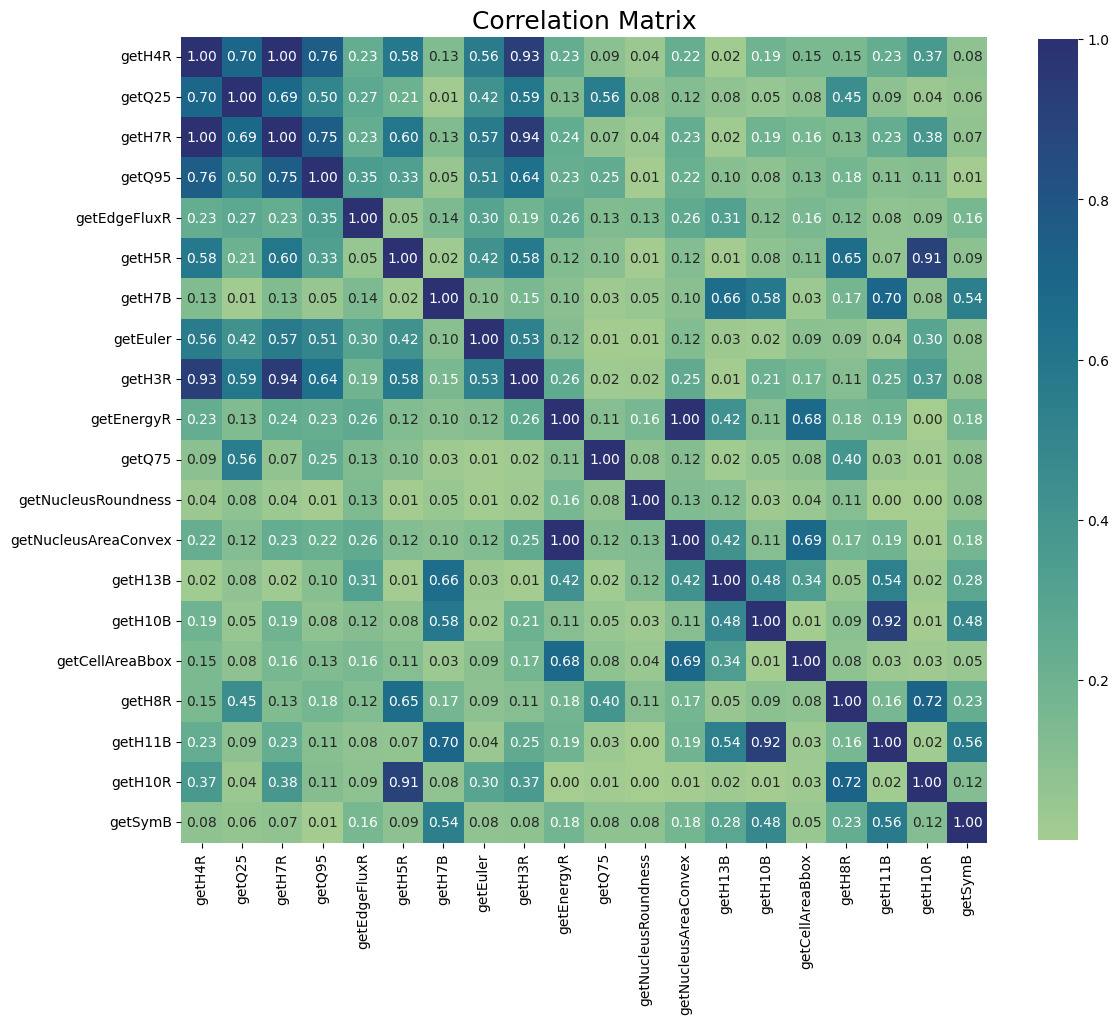

In [20]:
X_top_features = X[top_features]
correlation_matrix = X_top_features.corr()

###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix = X_top_features.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# 20 most important features using Shap values on all data

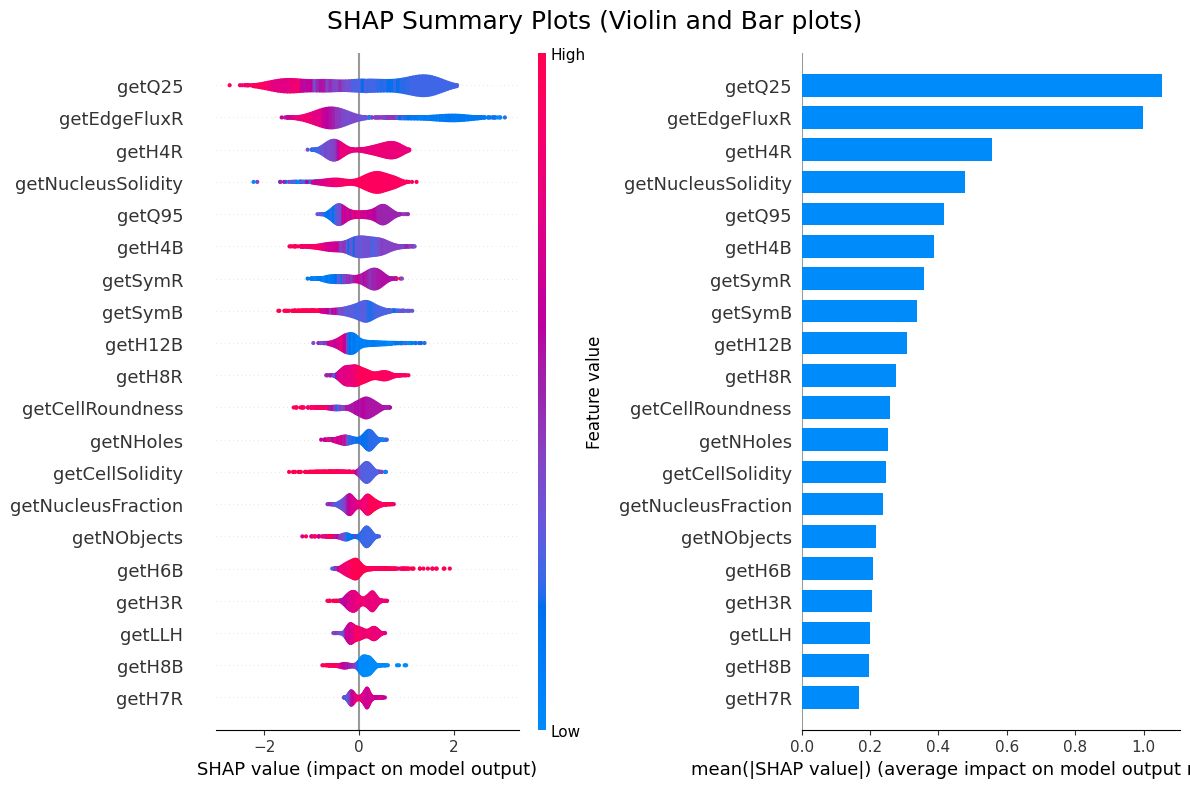

In [21]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type='bar', show = False, plot_size = (12, 8))
plt.sca(ax[0]) 

shap.summary_plot(shap_values, X_train, plot_type='violin', show = False, plot_size = (12, 8))
plt.sca(ax[1])
fig.suptitle('SHAP Summary Plots (Violin and Bar plots)', fontsize=18)
plt.tight_layout()
plt.show()

# Correlation matrix of the most important features (SHAP)

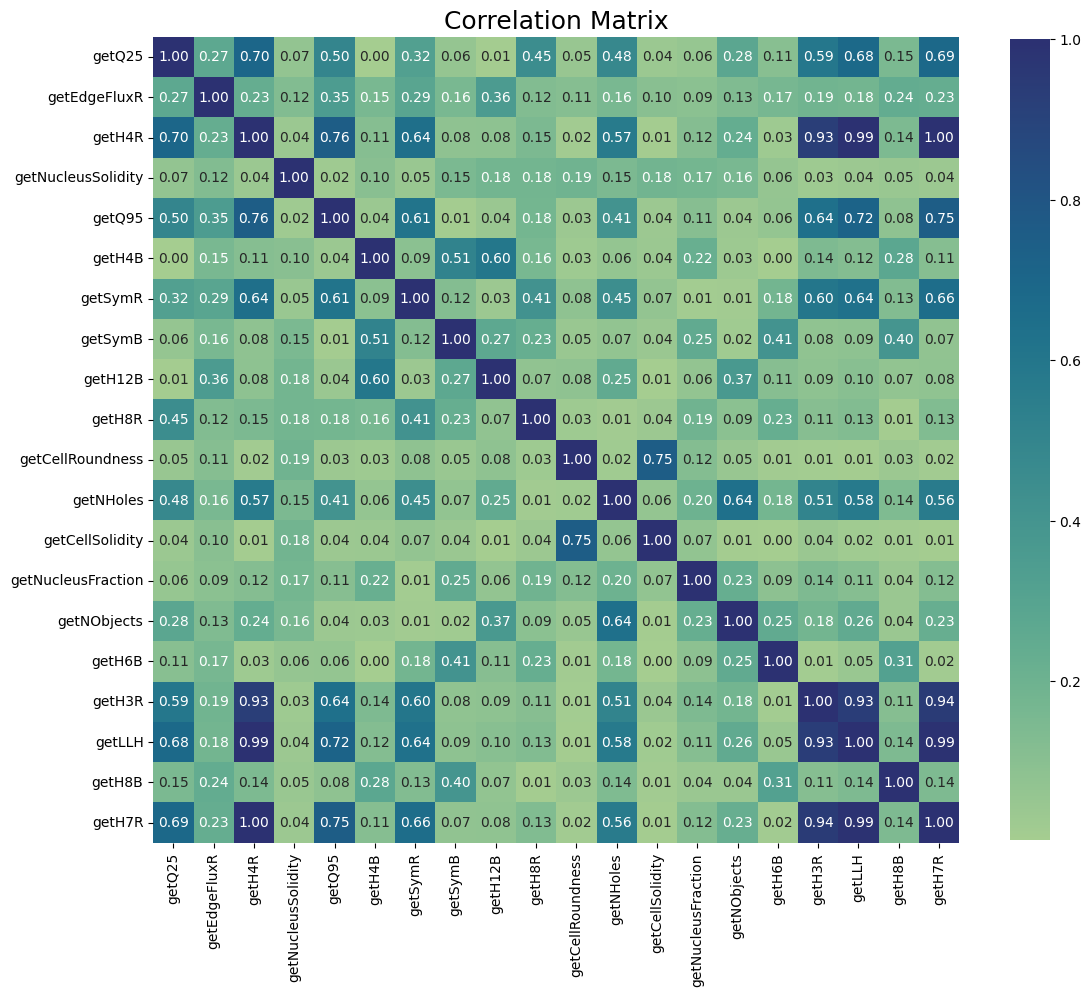

In [22]:
feature_importance = np.abs(shap_values).mean(axis=0)
top_indices_shap = np.argsort(feature_importance)[-20:][::-1]
top_features_shap = X.columns[top_indices_shap]

X_top_features_shap = X[top_features_shap]
correlation_matrix_shap = X_top_features_shap.corr()
###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix_shap = X_top_features_shap.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix_shap), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# Hyperparameter search (Bayes optimization) with Cross-Validation

In [23]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-04), np.log(0.3)),
    'dropout': hp.loguniform('dropout', np.log(1e-08), np.log(0.5)),
    'max_depth': hp.choice('max_depth', np.arange(3, 20, dtype=int)),
    'subsample': hp.uniform('subsample', 0.0, 1.0), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    # 'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 2000, 50, dtype=int)),
    # 'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-8), np.log(10)),
    # 'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(10)), 
    # 'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(10)),
    'scale_pos_weight': hp.loguniform('scale_pos_weight', np.log(1e-08), np.log(50)), 
    'lr_decay': hp.loguniform('lr_decay', np.log(1e-08), np.log(1.0))
}

def objective(params):
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **params, n_jobs = -1)
    scores = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='neg_log_loss')
    return -np.mean(scores)

trials = Trials()
start_time = time.time()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals = N_trials, trials=trials)
end_time = time.time()

best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

elapsed_time = end_time - start_time
print("Elapsed time of Bayesian optimization:", elapsed_time, "seconds \n")

 25%|██▌       | 25/100 [04:21<40:19, 32.26s/trial, best loss: 0.41788083270069365]

# Testing on the Validation data by training on the Train data

In [ ]:
from sklearn.model_selection import KFold

best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, **best_params, n_jobs=-1)

kf = KFold(n_splits=cv, shuffle=True, random_state=42)

val_logloss_scores = []
val_accuracy_scores = []

start_time = time.time()

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    best_model.fit(X_train, y_train)
    
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    val_logloss = log_loss(y_val, y_pred_proba)
    val_accuracy = accuracy_score(y_val, y_pred_proba.round())

    val_logloss_scores.append(val_logloss)
    val_accuracy_scores.append(val_accuracy)
    
end_time = time.time()

mean_logloss = np.mean(val_logloss_scores)
mean_accuracy = np.mean(val_accuracy_scores)

print("Mean LogLoss from Cross-Validation:", mean_logloss)
print("Mean Accuracy from Cross-Validation:", mean_accuracy)

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

Mean LogLoss from Cross-Validation: 0.38582967237241855
Mean Accuracy from Cross-Validation: 0.8226993865030675
Elapsed time: 20.28391122817993 seconds 



# Testing on the Test data by training on both the Train and Validation data

In [ ]:
best_model.fit(X_train_val, y_train_val)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print(f'On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

On the Test set:

Accuracy: 0.8186813186813187
LogLoss: 0.3810954313172836
Confusion matrix: [82 19] 
                  [14 67]


# Save best hyperparameters to a txt file in the local github repo

In [ ]:
# import json

# output = best_params

# def convert_to_native_types(obj):
#     if isinstance(obj, np.generic):
#         return obj.item()
#     elif isinstance(obj, dict):
#         return {key: convert_to_native_types(value) for key, value in obj.items()}
#     elif isinstance(obj, list):
#         return [convert_to_native_types(element) for element in obj]
#     else:
#         return obj

# output = convert_to_native_types(output)
# with open("Best_Hyperparameters", "w") as file:
#     json.dump(output, file, indent=4)

# print("Output saved to txt file successfully")